In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.chdir('..')

import pickle

import torch
import datasets
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers.modeling_outputs import CausalLMOutputWithPast

from tqdm import tqdm

from model import MemoryCell

In [2]:
import pandas as pd
# df = pd.DataFrame({'text': texts})
# df.to_csv('pg19_valid_1k_chunks.csv')
df = pd.read_csv('./notebooks/pg19_valid_1k_chunks.csv', index_col=0)
df.head()

,text
0,"'Let us stay here,' she exclaimed. 'The one ro..."
1,These lobsters don't realize that Jonesy's fas...
2,It certainly was not relief that he felt on di...
3,Down to 1765 the duty imposed was only one pen...
4,"And what was, perhaps, more extraordinary, tho..."


In [3]:
model_name = 'princeton-nlp/Sheared-LLaMA-1.3B'
tokenizer = AutoTokenizer.from_pretrained(model_name)
max_length = 128
N_mem_tokens = 1

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565 - if you loaded a llama tokenizer from a GGUF file you can ignore this message.


In [4]:
from pathlib import Path
from nltk import sent_tokenize
load_path = Path(f'./runs/{model_name}/mem_{N_mem_tokens}_len_{max_length}.pkl')
results = pickle.load(open(load_path, 'rb'))
sample_idx = 0
results = results[sample_idx]

In [5]:
sample_idx = results['args']['sample_idx']

text_sample = df['text'][sample_idx]

sentences = sent_tokenize(text_sample)
prefix_text = ' '.join(sentences[:len(sentences)//2])
suffix_text = ' '.join(sentences[len(sentences)//2:])

device = 'cuda'
dtype = torch.bfloat16
use_flash_attention_2 = True

suffix_inp = tokenizer(suffix_text, max_length=max_length, truncation=True, return_tensors='pt').to(device)

In [6]:
tokenizer.decode(suffix_inp['input_ids'][0])

"<s> His eyes met those of Kruse, who was kneeling on the other side of the bed. A sweet and happy smile stole over the pale countenance of the dying man, as he held out his hand to the captain. 'You see that my presentiments were correct,' he whispered, in a weak and failing voice. 'Now she will be happy, and you also; now you may love each other freely--for ever. And when you are happiest, sometimes spare a thought to me--an old man, who was ignorant that it was he who hindered your happiness--who went away"

In [1]:


model = AutoModelForCausalLM.from_pretrained(model_name, use_flash_attention_2=use_flash_attention_2)
model_with_memory = MemoryCell(model, N_mem_tokens, model.config.hidden_size)
model_with_memory.memory.data = torch.tensor(results['best_memory_params'])
model_with_memory.to(device)

with torch.cuda.amp.autocast(dtype=dtype):
    with torch.no_grad():
        out, _ = model_with_memory(**suffix_inp)
        print('with mem:', out.loss.item())

with torch.cuda.amp.autocast(dtype=dtype):
    with torch.no_grad():
        loss = model(**suffix_inp, labels=suffix_inp['input_ids']).loss.item()
print('no mem model:', loss)

# model = AutoModelForCausalLM.from_pretrained('EleutherAI/pythia-160m', use_flash_attention_2=True)
# model_with_memory = MemoryCell(model, N_mem_tokens, model.config.hidden_size)
# model_with_memory.to(device)

NameError: name 'AutoModelForCausalLM' is not defined

In [8]:
tokenizer.decode(suffix_inp['input_ids'][:,:100][0])

"<s> His eyes met those of Kruse, who was kneeling on the other side of the bed. A sweet and happy smile stole over the pale countenance of the dying man, as he held out his hand to the captain. 'You see that my presentiments were correct,' he whispered, in a weak and failing voice. 'Now she will be happy, and you also; now you may love each other freely--for ever. And when you are happiest, sometimes"

In [9]:
prefix_len = 15
tokenizer.decode(suffix_inp['input_ids'][:,:prefix_len][0])

'<s> His eyes met those of Kruse, who was kneeling on the'

In [10]:
# try to continue text with base model
with torch.cuda.amp.autocast(dtype=dtype):
    with torch.no_grad():
        out = model.generate(suffix_inp['input_ids'][:,:prefix_len], max_new_tokens=20)
        print(tokenizer.decode(out[0,prefix_len:]))

ground, his hands clasped together.

"I'm sorry," Kruse said


In [12]:
# try to continue text with compressed hidden
with torch.cuda.amp.autocast(dtype=dtype):
    with torch.no_grad():
        out = model_with_memory.generate(suffix_inp['input_ids'][:,:15], memory_state=None, attention_mask=None, max_new_tokens=20)
        print(tokenizer.decode(out[0]))

other side of the bed. A sweet and happy smile stole over the pale countenance of


In [13]:
# try to continue text with compressed hidden, beyond that was compressed
with torch.cuda.amp.autocast(dtype=dtype):
    with torch.no_grad():
        out = model_with_memory.generate(suffix_inp['input_ids'][:,:15], memory_state=None, attention_mask=None, max_new_tokens=200)
        print(tokenizer.decode(out[0][105:]))

indered your happiness--who went away from the world a poor dying man, for the love which you now feel for each other. A soft, ' Their voices sank away as each heard the other say: 'Now I love God, and now I love thee.'--But the clear, sweet voice of the dying man was heard first: 'Now God knows everything, and now He knows that we two love each other. And the last words, which were whisper


In [14]:
tokenizer.decode(tokenizer(suffix_text, max_length=200, truncation=True, return_tensors='pt').to(device)['input_ids'][0][120:190])

"indered your happiness--who went away when he discovered it. Farewell, my son. Be kind to her, whom we both love!' Gregers drew a deep sigh, clasped his feeble hands, and his spirit fled to other worlds!' * * * A month later, two persons were sitting in one of the"

In [11]:
# try to ask generate text from ""
qa_idx = 0

qa_inp_text = f""
qa_inp = tokenizer(qa_inp_text, max_length=max_length, truncation=True, return_tensors='pt').to(device)

print(f'\nmodel input:\n{qa_inp_text}')
print('\nmodel output:\n')

with torch.cuda.amp.autocast(dtype=dtype):
    with torch.no_grad():
        out = model_with_memory.generate(qa_inp['input_ids'], memory_state=None, attention_mask=None, max_new_tokens=40)#, do_sample=True)
        print(tokenizer.decode(out[0]))


model input:


model output:

His eyes met those of Kruse, who was kneeling on the other side of the bed. A sweet and happy smile stole over the pale countenance of the dying man, as he


In [12]:
# generated by chatgpt
qa_pairs = [[
  {
    "question": "Who was kneeling on the other side of the bed?",
    "answer": "Kruse."
  },
  {
    "question": "What appeared on the dying man's face?",
    "answer": "A smile."
  },
  {
    "question": "What did the dying man say was correct?",
    "answer": "His presentiments."
  },
  {
    "question": "Who will be happy now?",
    "answer": "She and the captain."
  },
  {
    "question": "How did the dying man speak?",
    "answer": "Weakly."
  }
],
[
  {
    "question": "Who gave the notion to pick another good man?",
    "answer": "Frazer."
  },
  {
    "question": "Who was fooled by their own plan?",
    "answer": "Garrity."
  },
  {
    "question": "What does Locke suggest Garrity is doing?",
    "answer": "Fooling himself."
  },
  {
    "question": "What quote did Locke mention?",
    "answer": "'The best-laid plans o' mice and men.'"
  },
  {
    "question": "Who was left glaring after Locke?",
    "answer": "The owner of the Rockets."
  }
],
[
  {
    "question": "What have all been carried away by?",
    "answer": "Sympathies."
  },
  {
    "question": "Who is convinced that no man can say the evidence warrants the discharge?",
    "answer": "The speaker."
  },
  {
    "question": "What does the speaker want to do?",
    "answer": "Set him free."
  },
  {
    "question": "Does the speaker believe the defendant's story?",
    "answer": "Yes, the speaker is inclined to believe it."
  },
  {
    "question": "What are they bound by as honest men?",
    "answer": "The requirements of the law."
  },
  {
    "question": "What did the Court clearly state?",
    "answer": "The law in this case."
  }
]

]

In [121]:
# try to ask question to compressed hidden with text
qa_idx = 2

qa_inp_text = f"Question: {qa_pairs[sample_idx][qa_idx]['question']} Answer:"
qa_inp = tokenizer(qa_inp_text, max_length=max_length, truncation=True, return_tensors='pt').to(device)

print(f"Question: {qa_pairs[sample_idx][qa_idx]['question']}")
print(f"Correct answer: {qa_pairs[sample_idx][qa_idx]['answer']}")
print(f'\nmodel input:\n{qa_inp_text}')
print('\nmodel output:\n')

with torch.cuda.amp.autocast(dtype=dtype):
    with torch.no_grad():
        out = model_with_memory.generate(qa_inp['input_ids'], memory_state=None, attention_mask=None, max_new_tokens=20)#, do_sample=True)
        print(tokenizer.decode(out[0]))

Question: What did the dying man say was correct?
Correct answer: His presentiments.

model input:
Question: What did the dying man say was correct? Answer:

model output:

He said, "I have a brain."
I'm sure you're not a doctor


In [119]:
# try to ask question to full text
qa_idx = 1
text = tokenizer.decode(suffix_inp['input_ids'][:,:121][0], skip_special_tokens=True)
qa_inp_text = f"{text} END. Question: {qa_pairs[sample_idx][qa_idx]['question']} Answer:"
qa_inp = tokenizer(qa_inp_text, return_tensors='pt').to(device)

print(f"Question: {qa_pairs[sample_idx][qa_idx]['question']}")
print(f"Correct answer: {qa_pairs[sample_idx][qa_idx]['answer']}")

print(f'\nmodel input:\n{qa_inp_text}')

print('\nmodel output:\n')

with torch.cuda.amp.autocast(dtype=dtype):
    with torch.no_grad():
        out = model.generate(qa_inp['input_ids'], max_new_tokens=20)
        print(tokenizer.decode(out[0, qa_inp['input_ids'].shape[-1]:]))

Question: What appeared on the dying man's face?
Correct answer: A smile.

model input:
His eyes met those of Kruse, who was kneeling on the other side of the bed. A sweet and happy smile stole over the pale countenance of the dying man, as he held out his hand to the captain. 'You see that my presentiments were correct,' he whispered, in a weak and failing voice. 'Now she will be happy, and you also; now you may love each other freely--for ever. And when you are happiest, sometimes spare a thought to me--an old man, who was ignorant that it was he who hinder END. Question: What appeared on the dying man's face? Answer:

model output:

A smile.
The captain's eyes were fixed on the dying man's face, and


In [15]:
# attention maps

In [38]:
model_no_FA = AutoModelForCausalLM.from_pretrained(model_name, use_flash_attention_2=False)
model_with_memory_no_FA = MemoryCell(model_no_FA, N_mem_tokens, model.config.hidden_size)
model_with_memory_no_FA.memory.data = torch.tensor(results['best_memory_params'])
model_with_memory_no_FA.to(device)

with torch.cuda.amp.autocast(dtype=dtype):
    with torch.no_grad():
        out, _ = model_with_memory(**suffix_inp)
        print('with mem:', out.loss.item())

with torch.cuda.amp.autocast(dtype=dtype):
    with torch.no_grad():
        out, _ = model_with_memory_no_FA(**suffix_inp)
        print('with mem, no FA:', out.loss.item())

with torch.cuda.amp.autocast(dtype=dtype):
    with torch.no_grad():
        loss = model(**suffix_inp, labels=suffix_inp['input_ids']).loss.item()
        print('no mem model:', loss)

with torch.cuda.amp.autocast(dtype=dtype):
    with torch.no_grad():
        loss = model_no_FA(**suffix_inp, labels=suffix_inp['input_ids']).loss.item()
        print('no mem model, no FA:', loss)

with mem: 0.06965792179107666
with mem, no FA: 0.0692208856344223
no mem model: 2.836017608642578
no mem model, no FA: 2.836109161376953


In [55]:
import matplotlib.pyplot as plt
def plot_attention_weights(attentions, tokens, layer, y_tokens=None, filename='att.png', save=False,
                           figsize=(30, 90), layout=(6, 2), fontsize=10, caption='Head', cmap='Reds', norm=None):
    # attentions n_layers x n_heads x len x len
    fig = plt.figure(figsize=figsize)
    if y_tokens is None:
        y_tokens = tokens

    attention = attentions[layer]

    for head in range(attention.shape[0]):
        ax = fig.add_subplot(*layout, head+1)

        # plot the attention weights
        ax.matshow(attention[head][:len(y_tokens), :len(tokens)], cmap=cmap, norm=norm)

        fontdict = {'fontsize': fontsize}

        ax.set_xticks(range(len(tokens)))
        ax.set_yticks(range(len(y_tokens)))
        ax.set_yticklabels(y_tokens, fontdict=fontdict)

        ax.set_xticklabels(tokens, fontdict=fontdict, rotation=90)

        ax.set_xlabel(f'{caption} {head+1}', fontdict)

    plt.tight_layout()
    if save:
        plt.savefig(filename)
    plt.show()

In [112]:
text = tokenizer.decode(suffix_inp['input_ids'][:,:20][0], skip_special_tokens=True)
qa_inp_text = f'{text}'
# qa_inp_text = f"END. Question: {qa_pairs[sample_idx][qa_idx]['question']} Answer: A smile."
qa_inp = tokenizer(qa_inp_text, return_tensors='pt').to(device)

with torch.cuda.amp.autocast(dtype=dtype):
    with torch.no_grad():
        out, _ = model_with_memory_no_FA(**qa_inp, output_attentions=True)
        print('loss with mem:', out.loss.item())

print(len(out.attentions))
for el in out.attentions:
    print(el.shape)

loss with mem: 0.05458396300673485
24
torch.Size([1, 16, 21, 21])
torch.Size([1, 16, 21, 21])
torch.Size([1, 16, 21, 21])
torch.Size([1, 16, 21, 21])
torch.Size([1, 16, 21, 21])
torch.Size([1, 16, 21, 21])
torch.Size([1, 16, 21, 21])
torch.Size([1, 16, 21, 21])
torch.Size([1, 16, 21, 21])
torch.Size([1, 16, 21, 21])
torch.Size([1, 16, 21, 21])
torch.Size([1, 16, 21, 21])
torch.Size([1, 16, 21, 21])
torch.Size([1, 16, 21, 21])
torch.Size([1, 16, 21, 21])
torch.Size([1, 16, 21, 21])
torch.Size([1, 16, 21, 21])
torch.Size([1, 16, 21, 21])
torch.Size([1, 16, 21, 21])
torch.Size([1, 16, 21, 21])
torch.Size([1, 16, 21, 21])
torch.Size([1, 16, 21, 21])
torch.Size([1, 16, 21, 21])
torch.Size([1, 16, 21, 21])


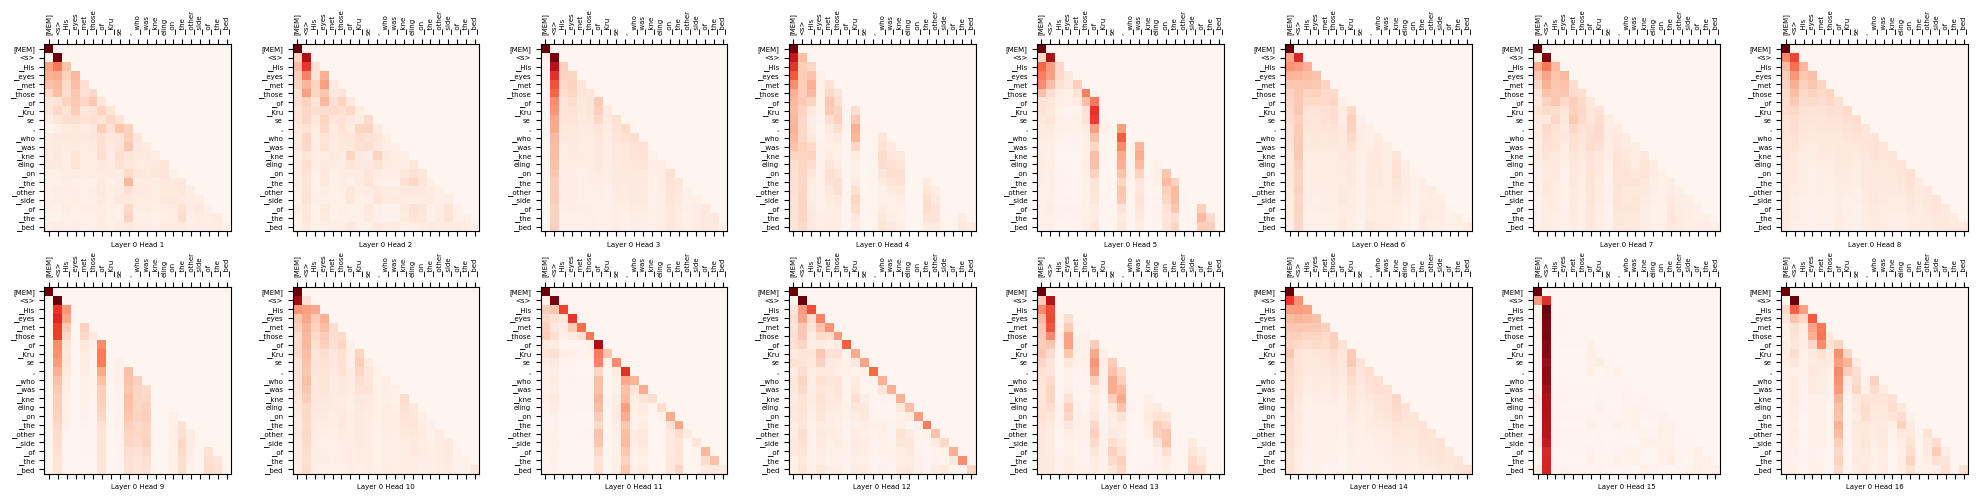

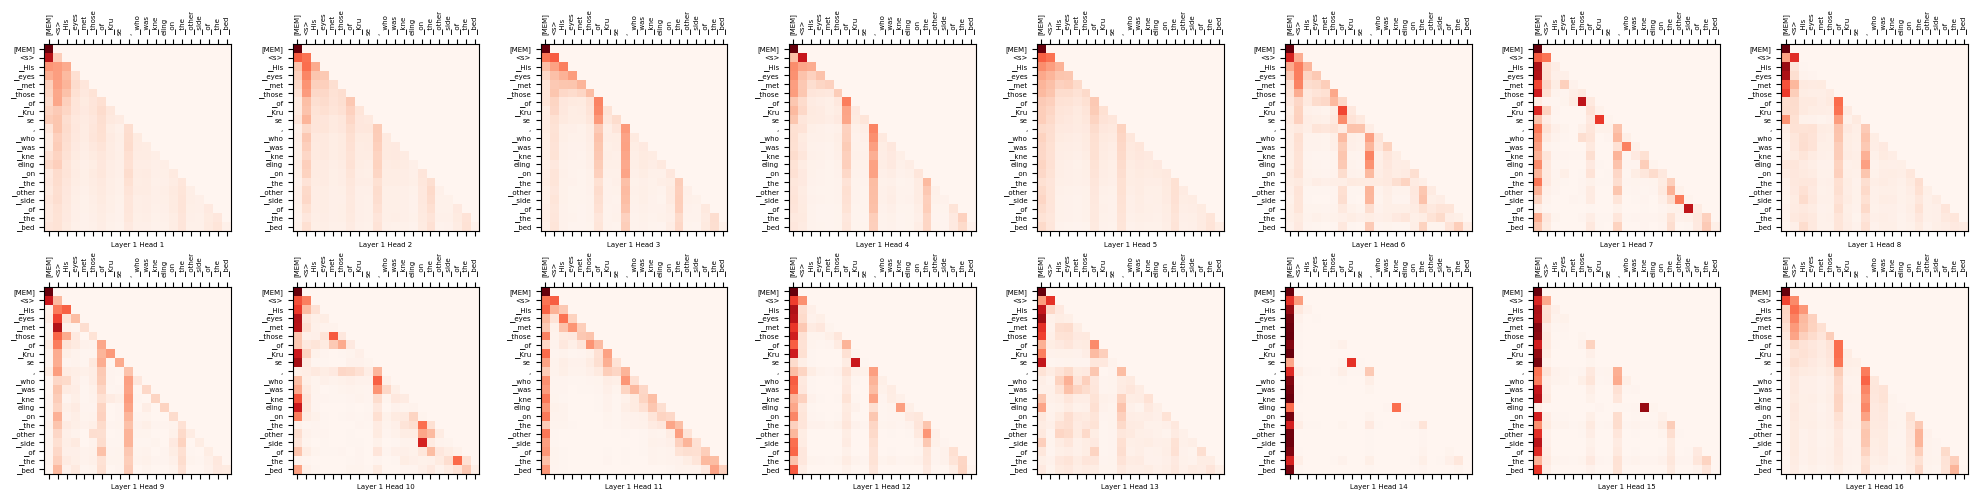

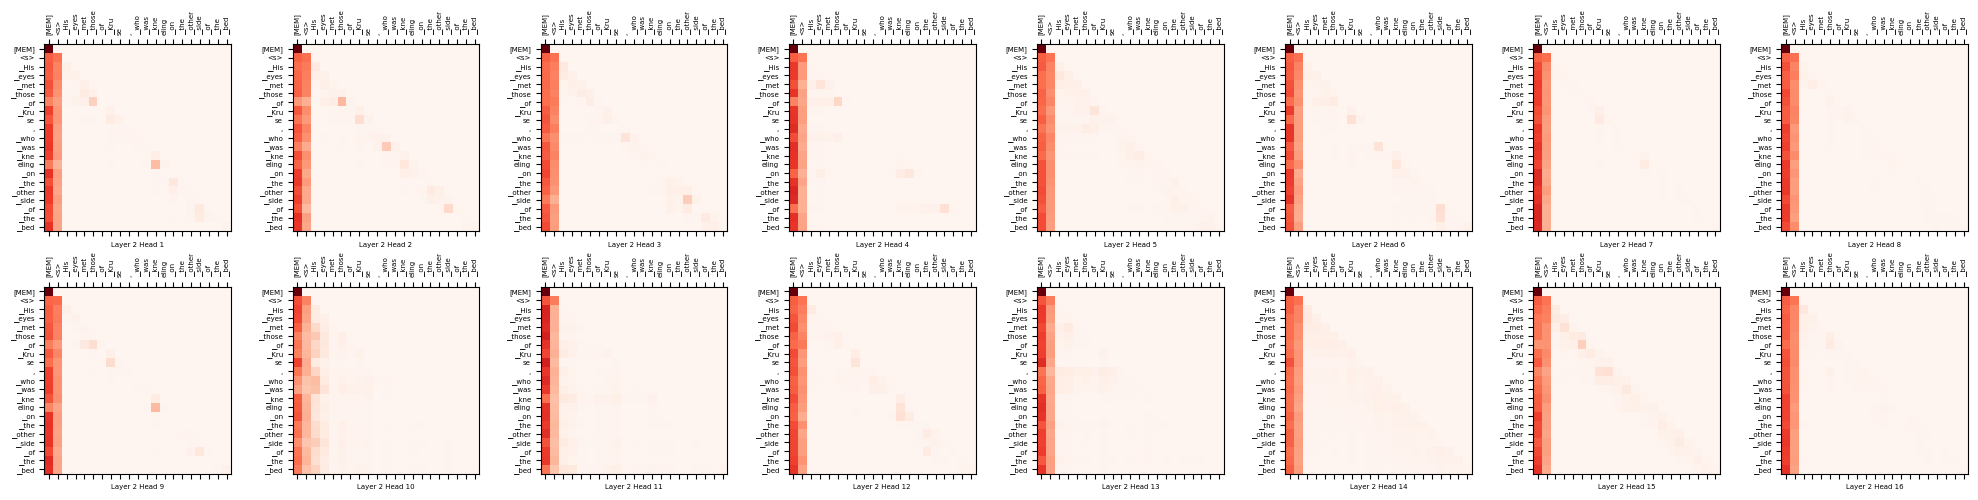

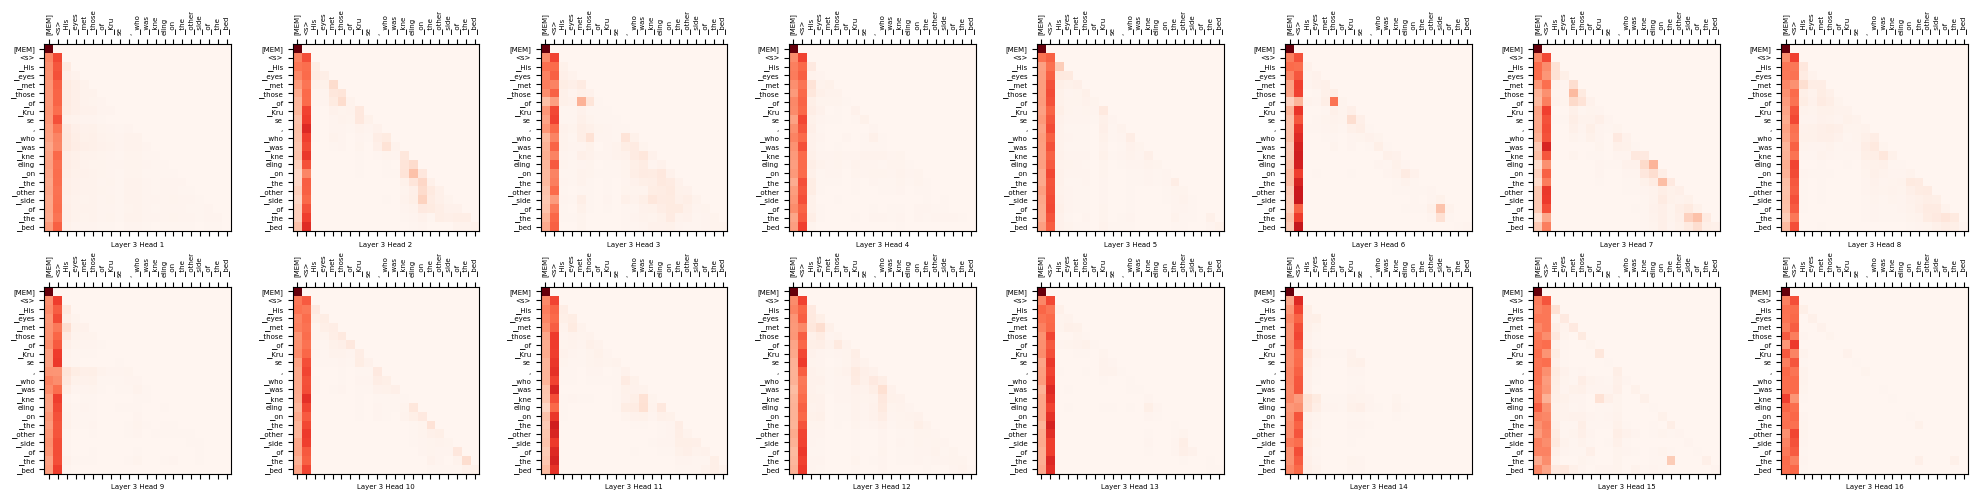

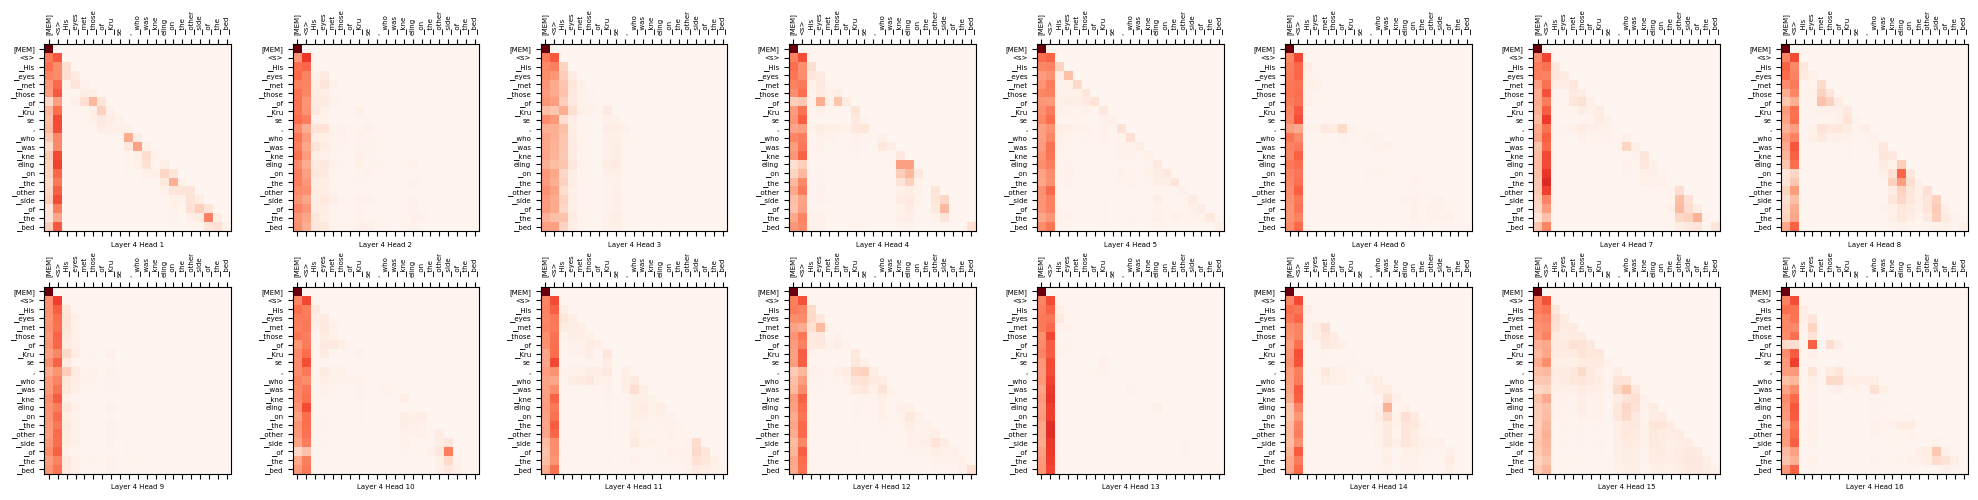

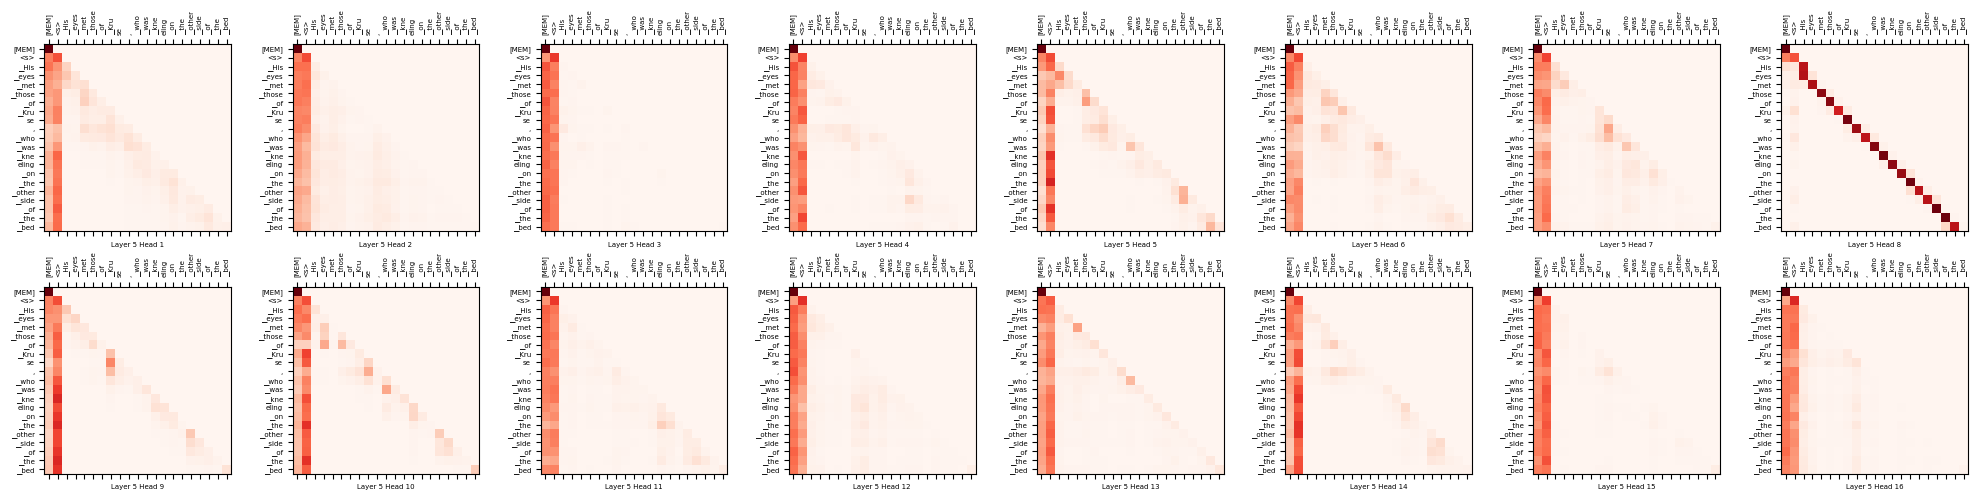

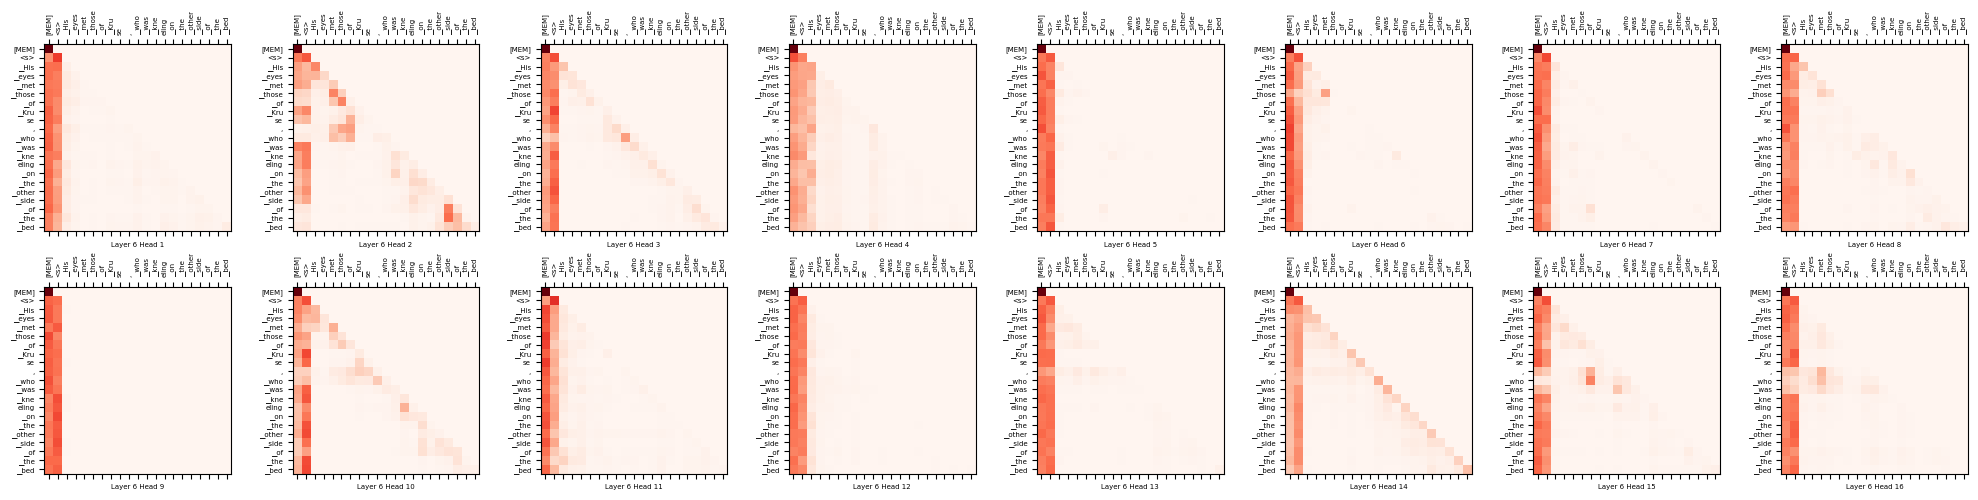

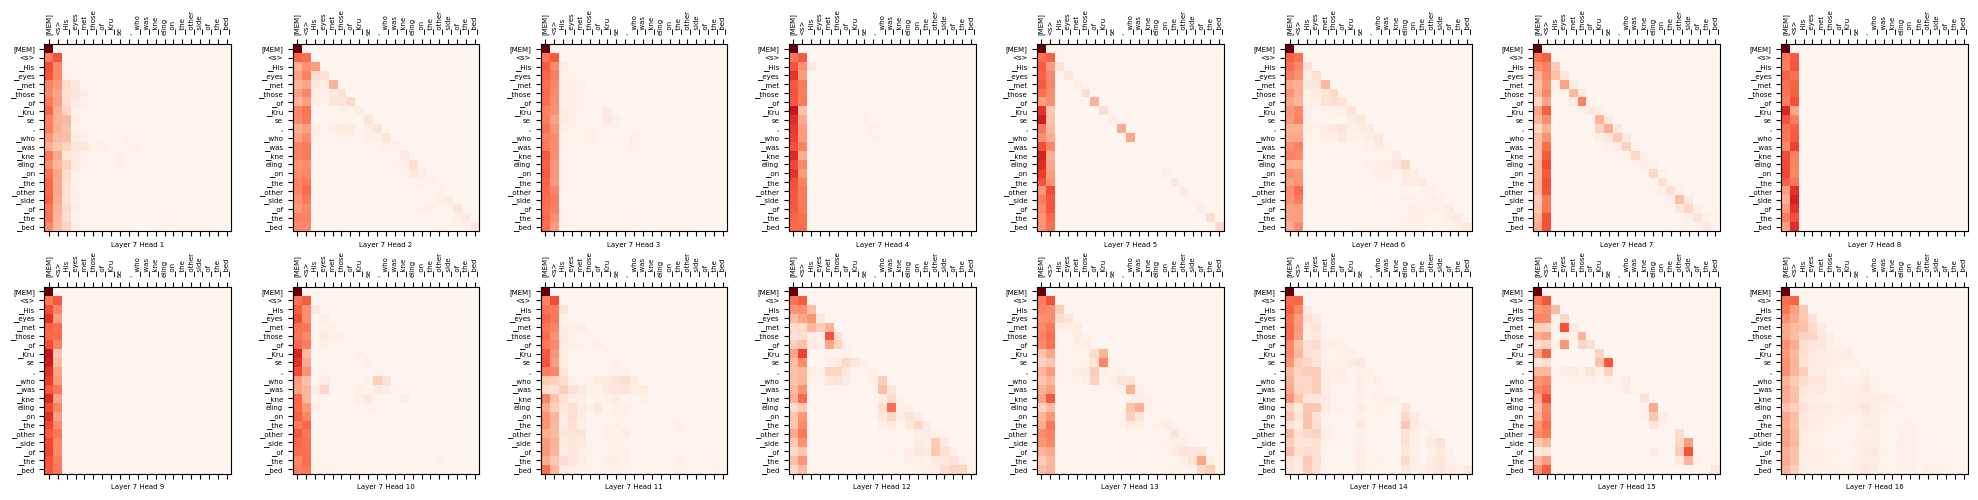

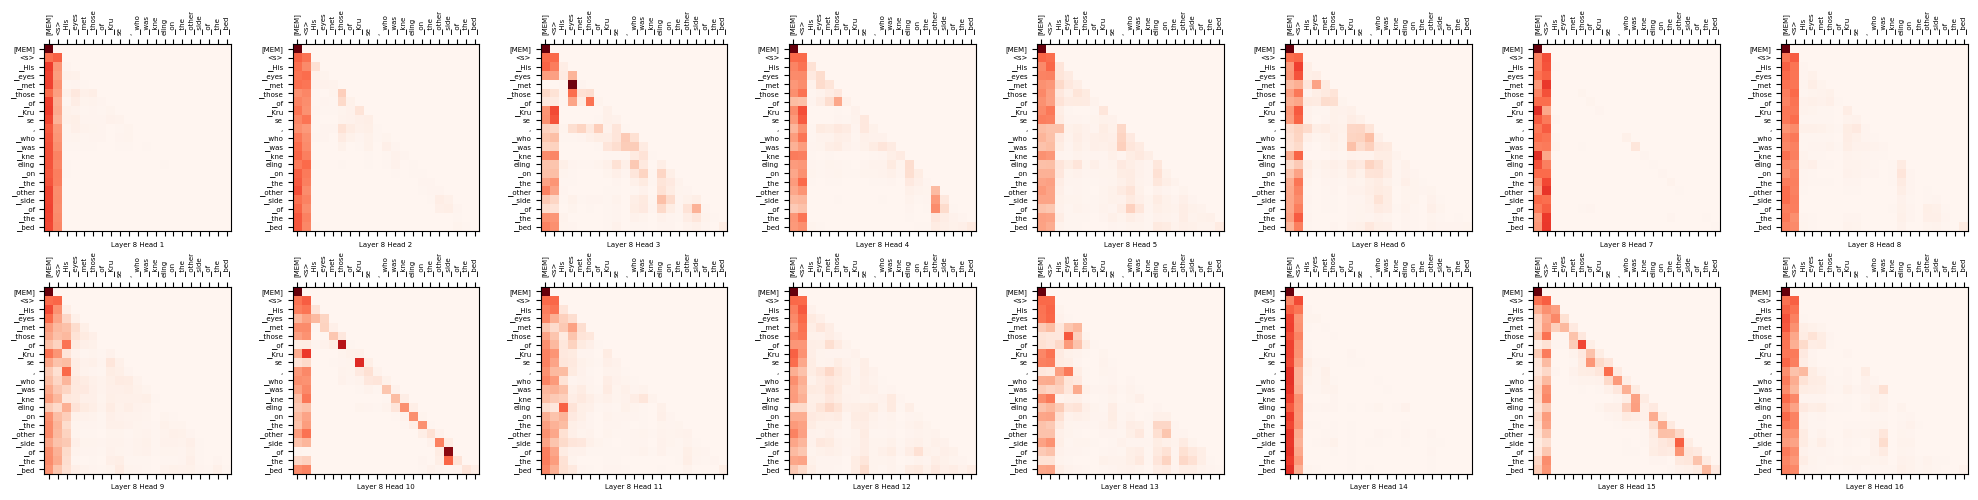

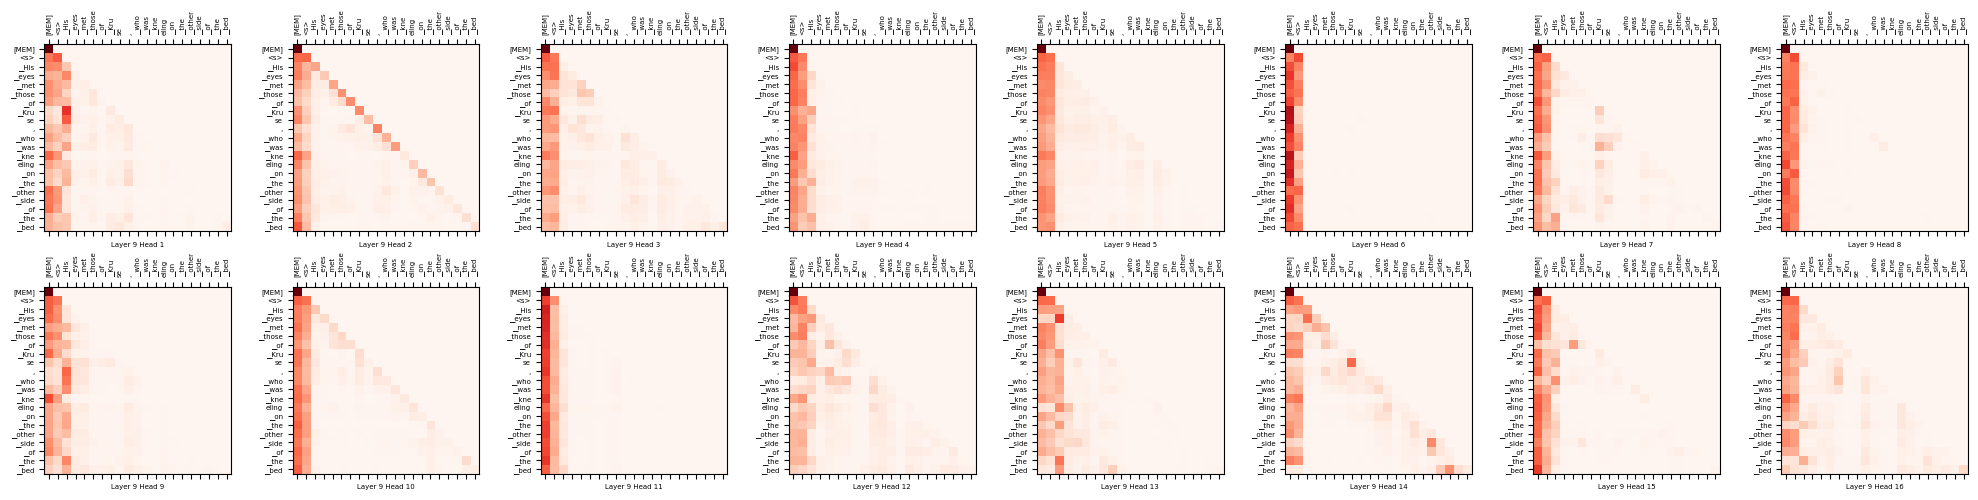

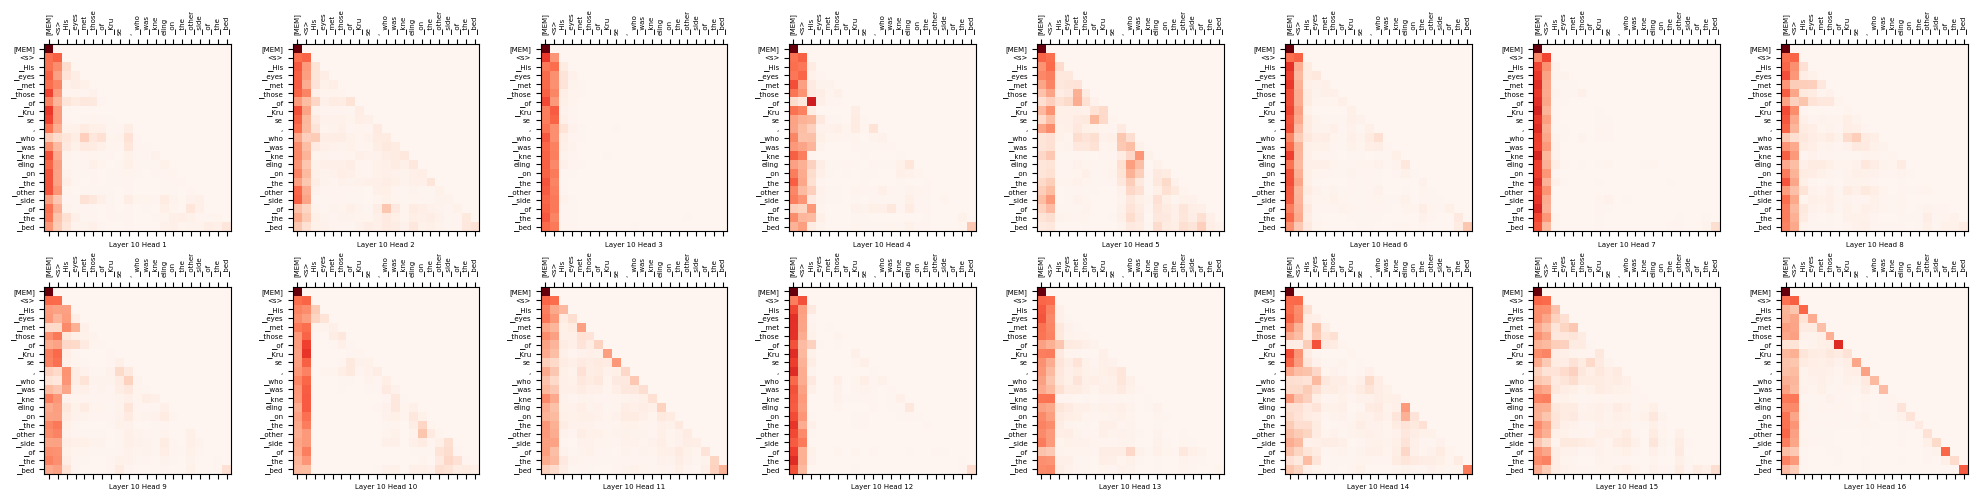

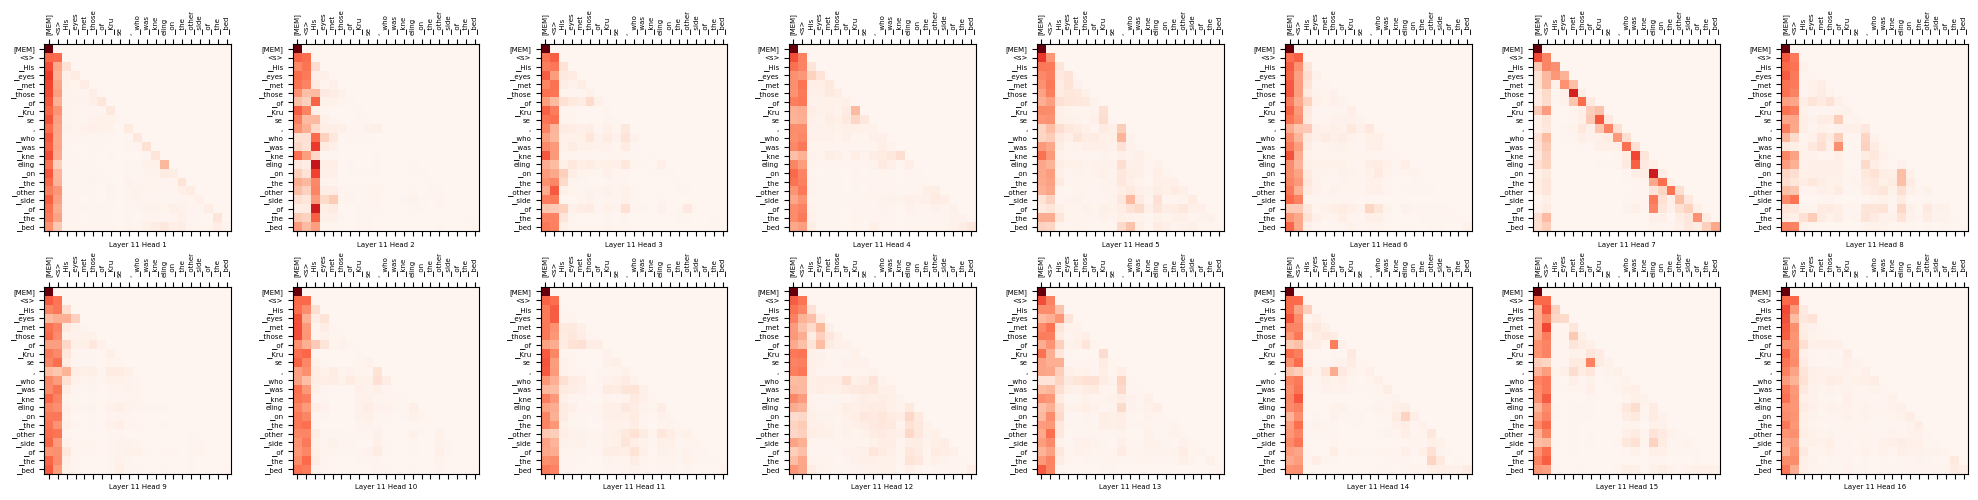

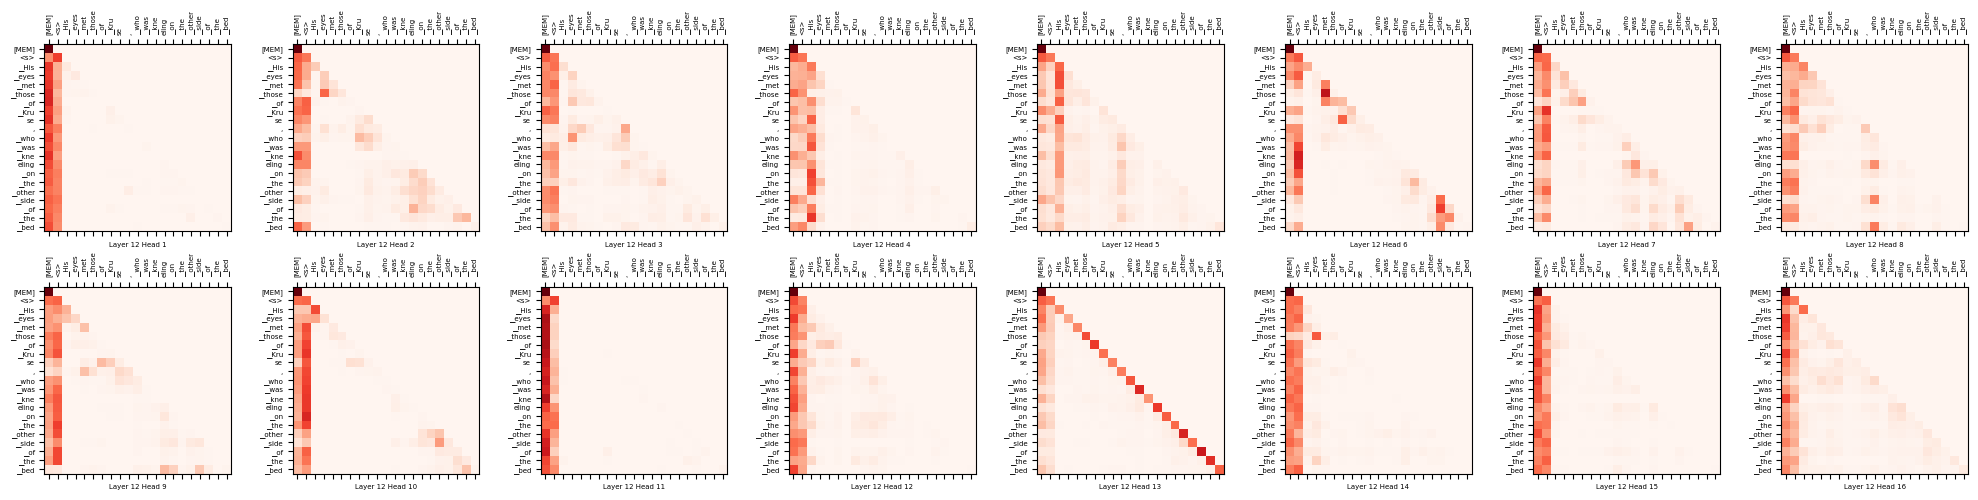

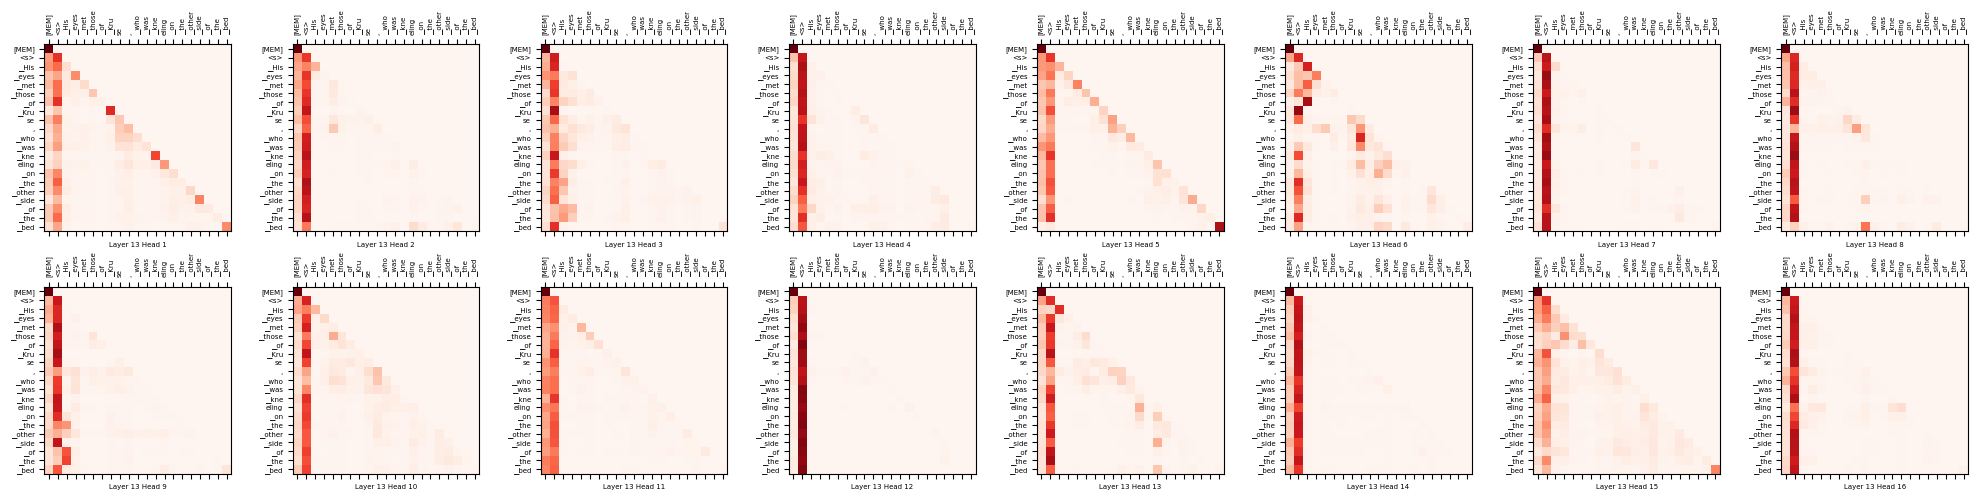

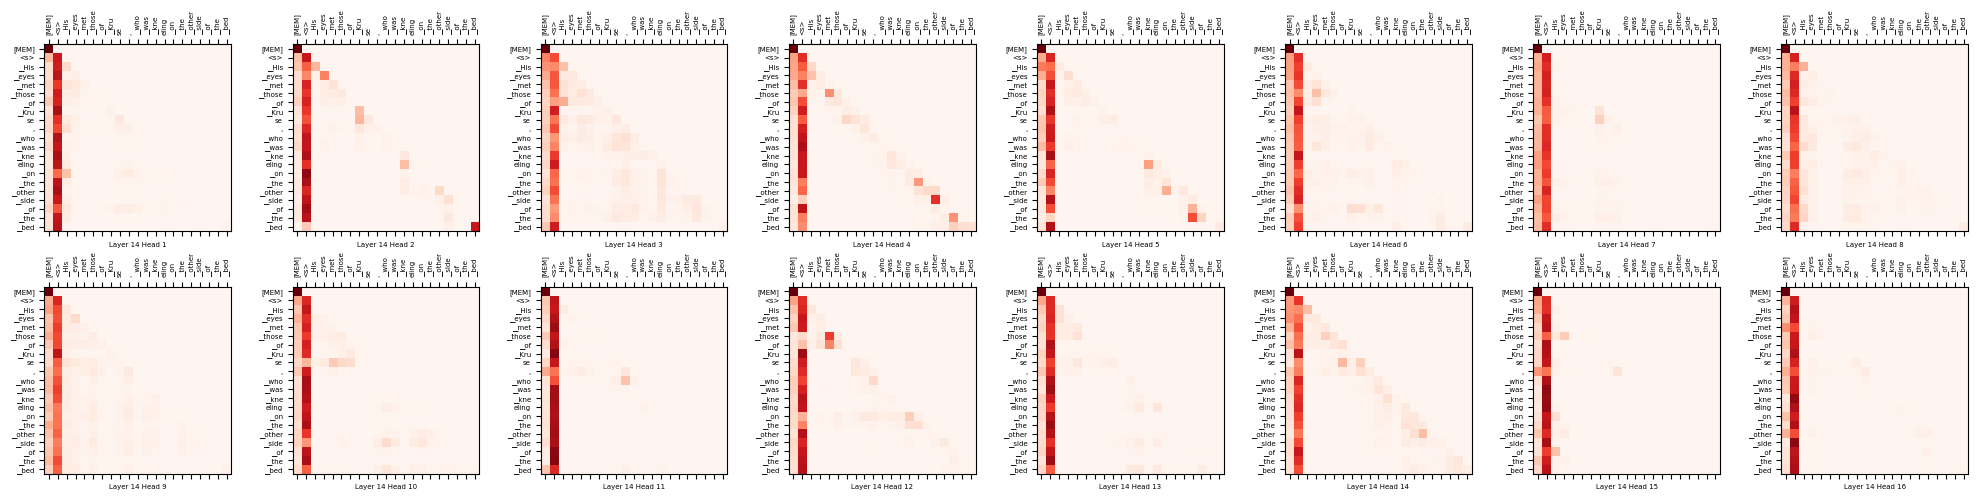

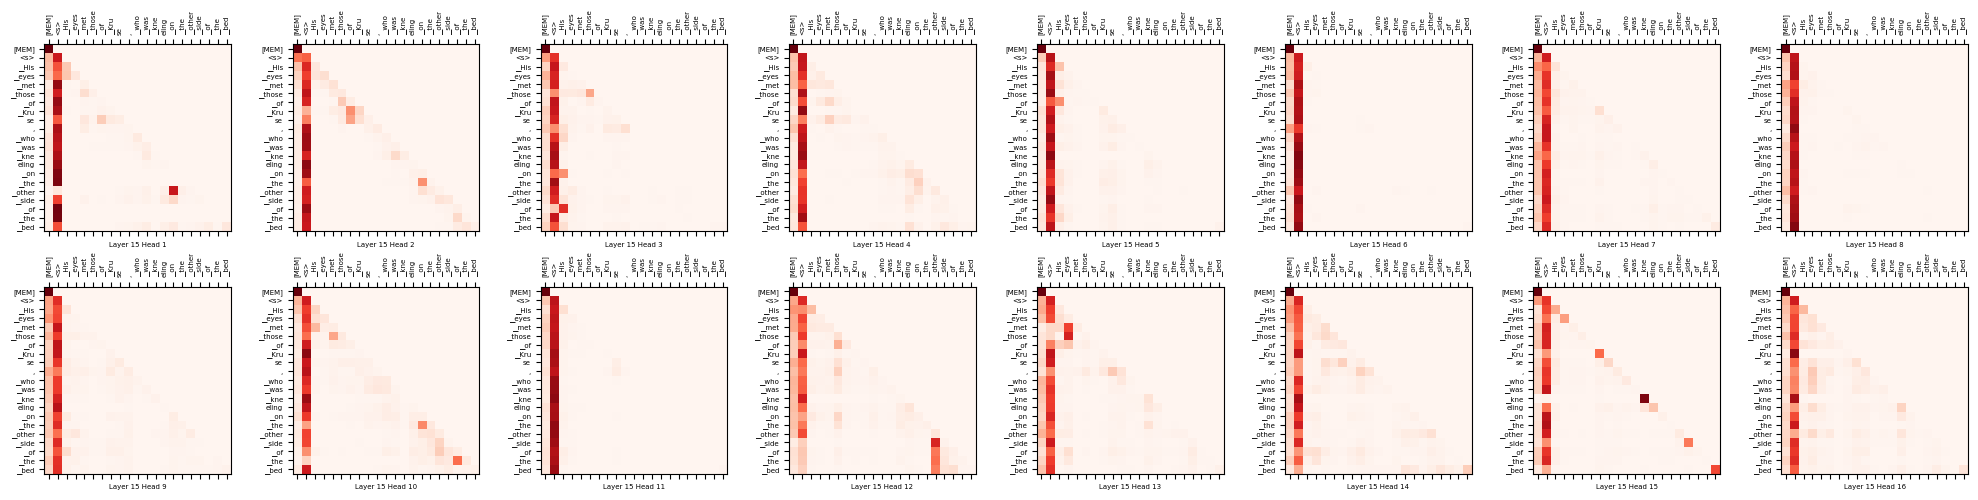

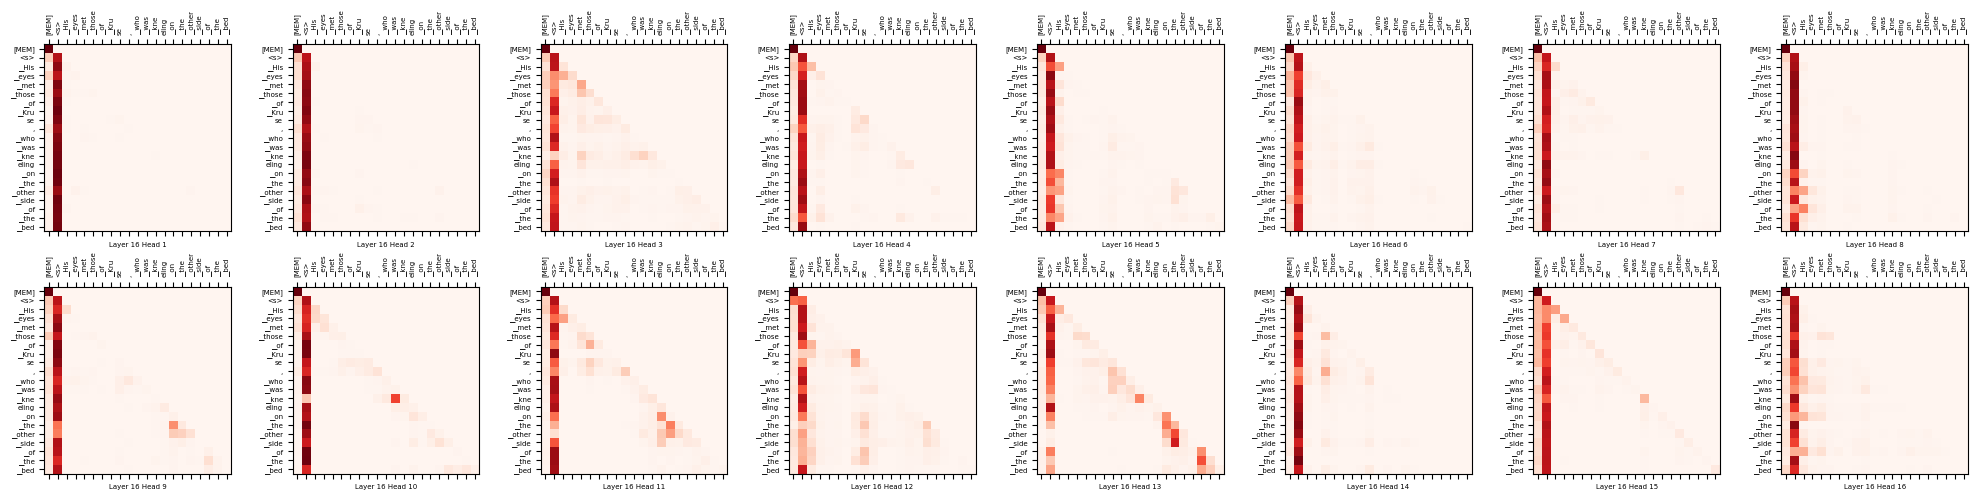

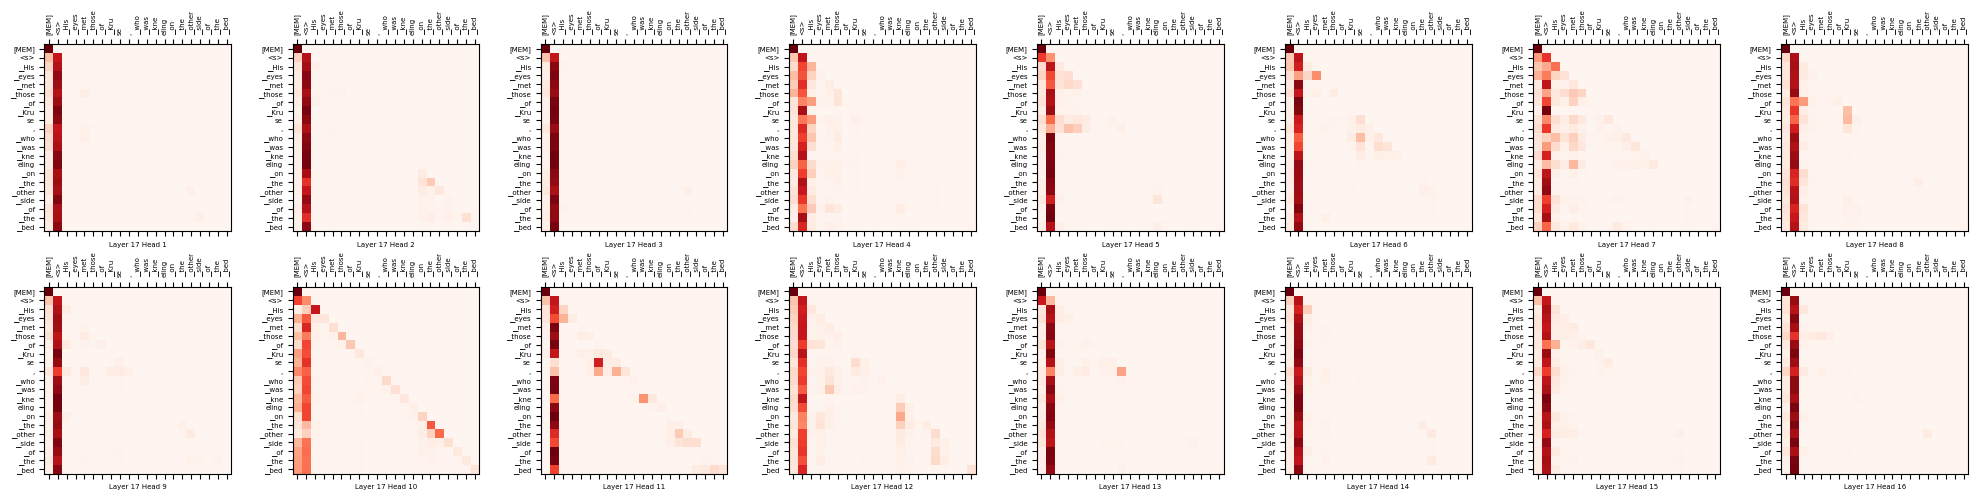

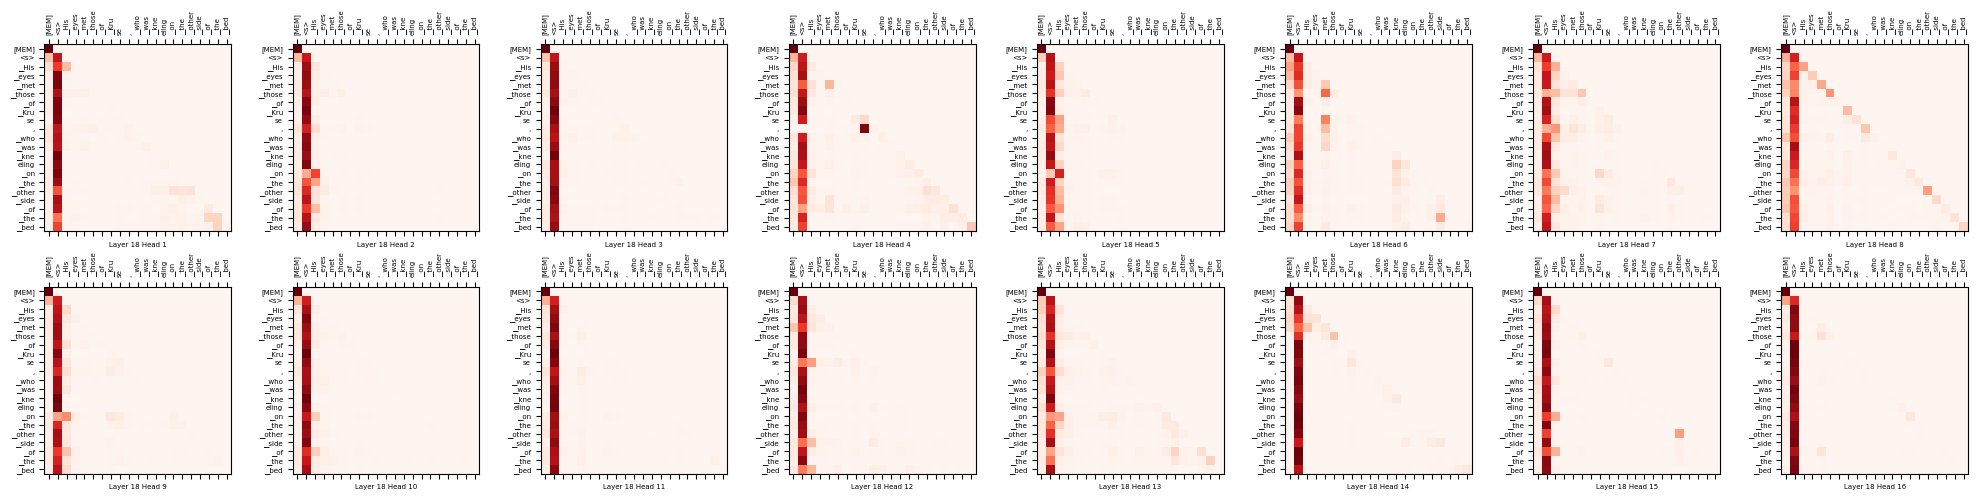

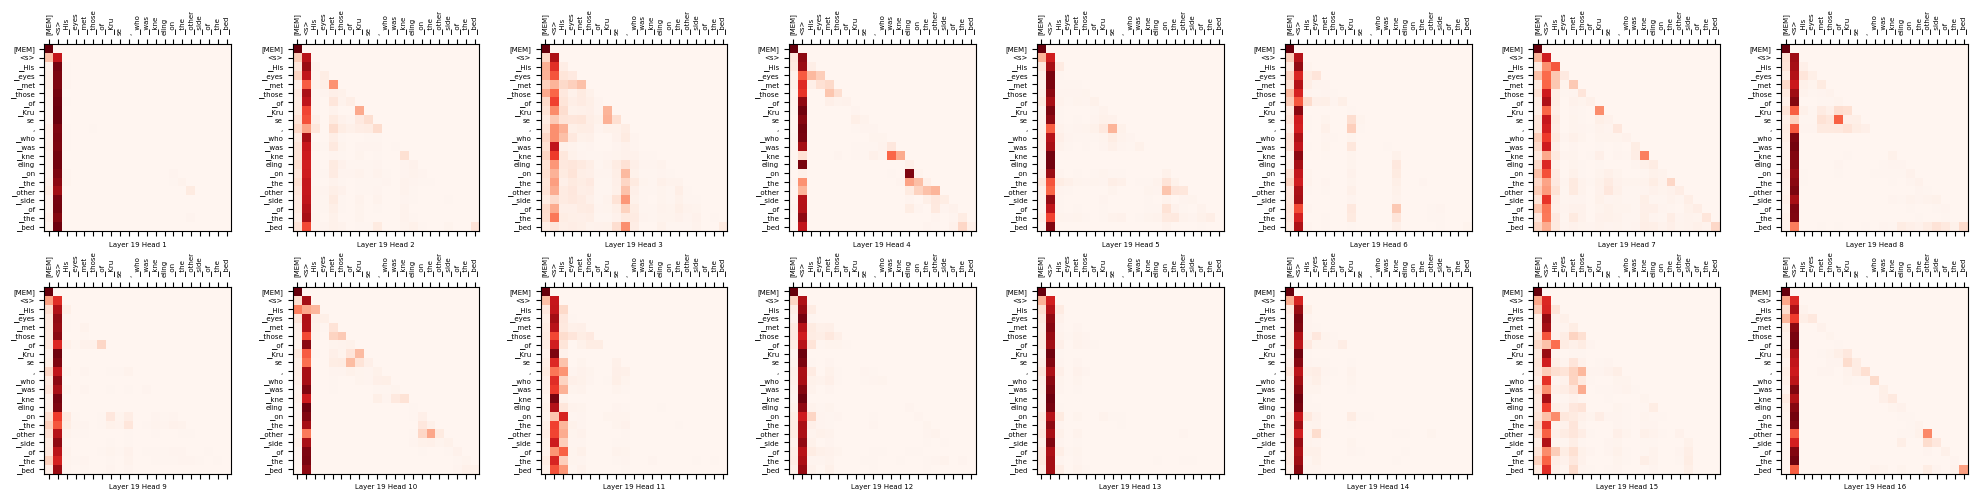

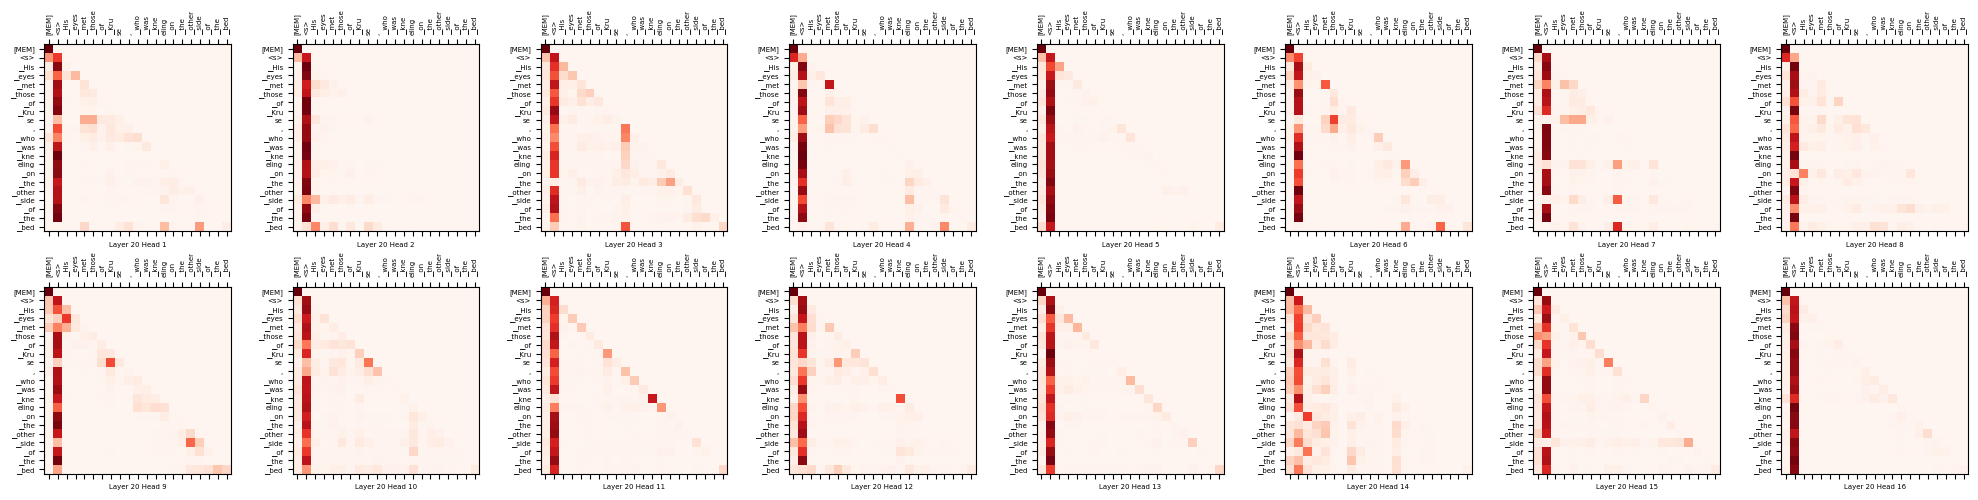

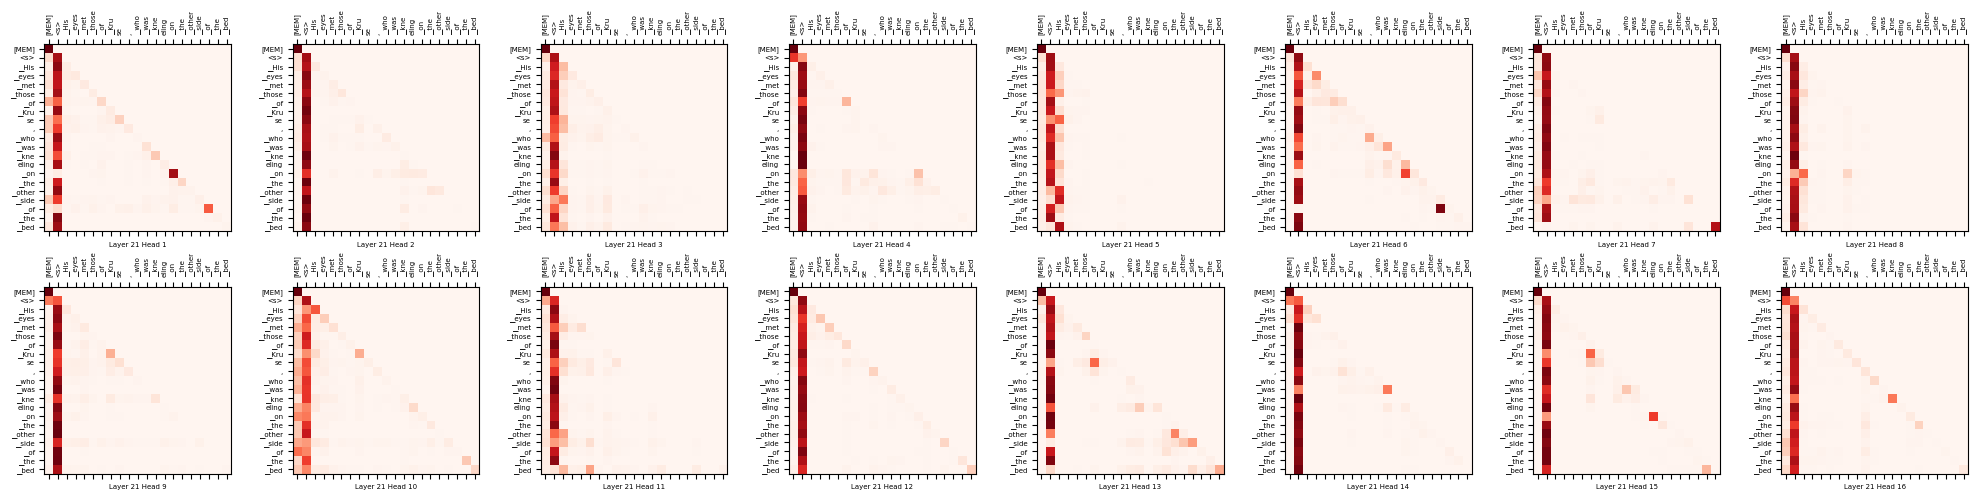

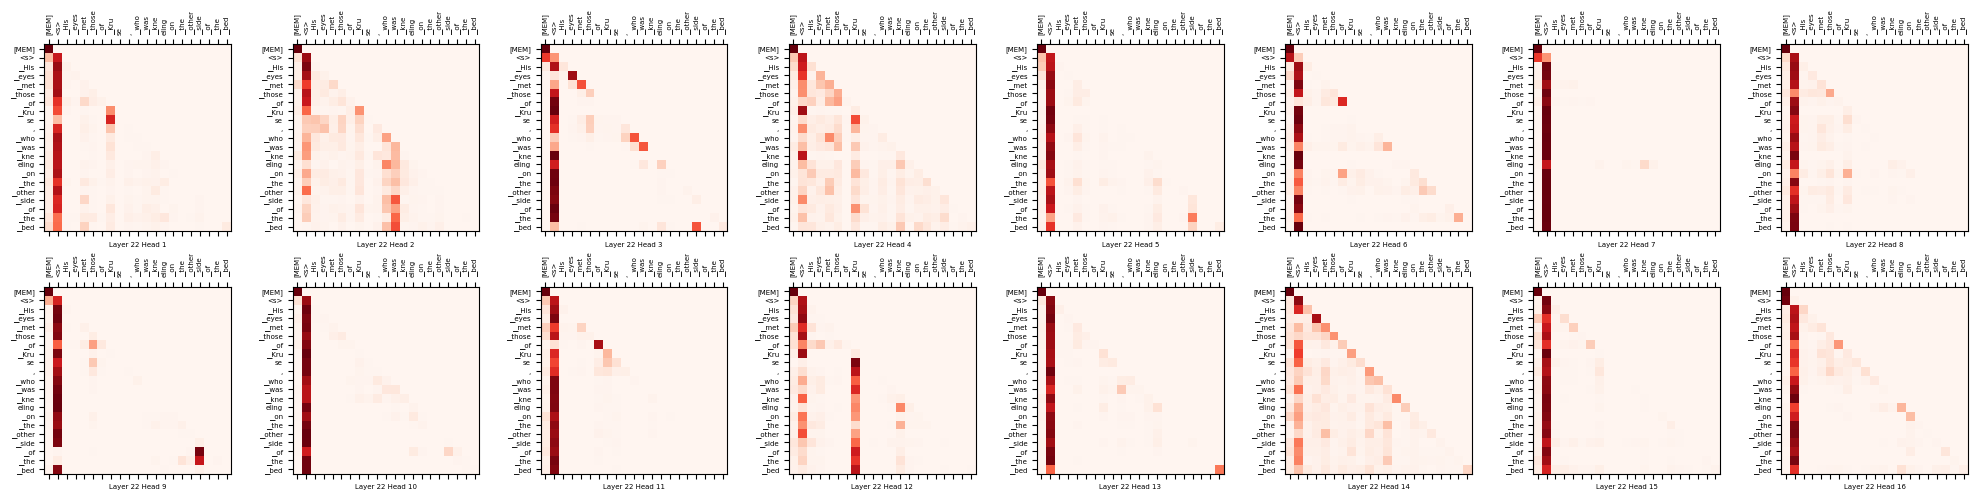

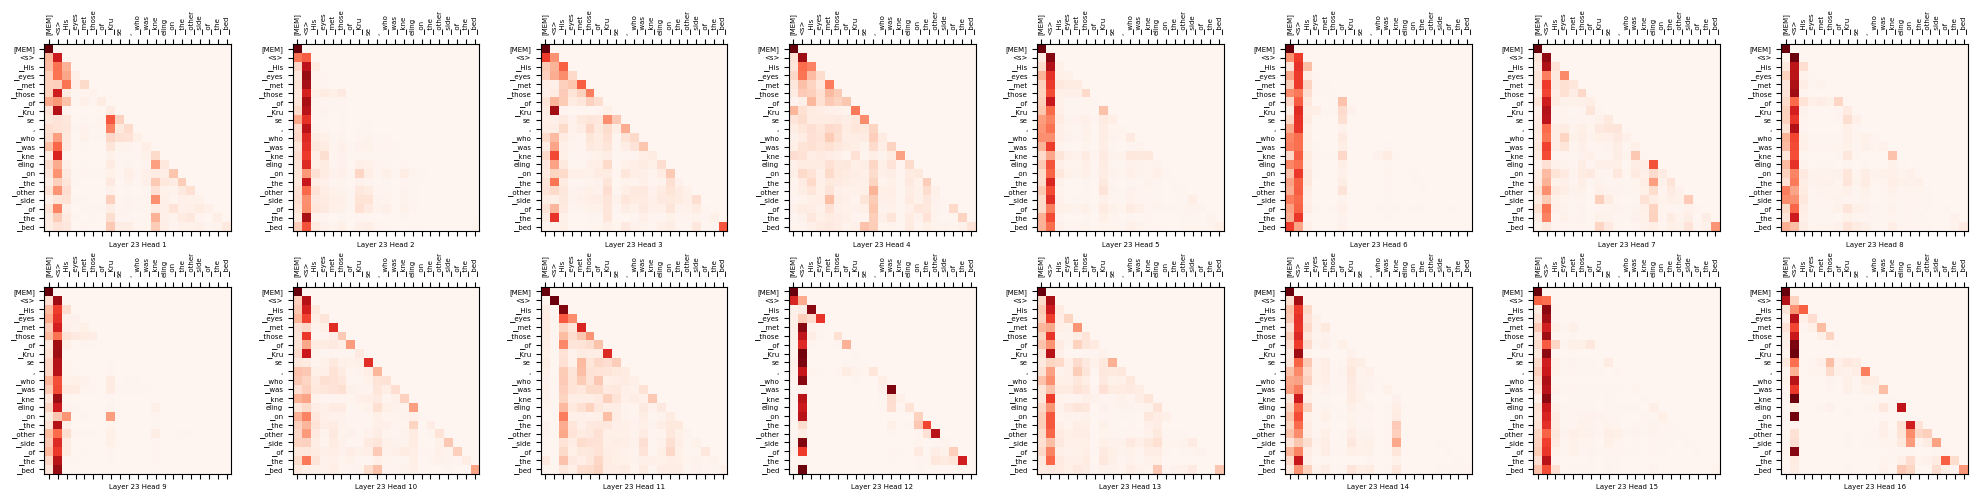

In [113]:
attention_weights = torch.stack(out.attentions, axis=1)[0].cpu().numpy()
for i in range(len(attention_weights)):
    plot_attention_weights(attention_weights,
                           tokens=['[MEM]'] + tokenizer.convert_ids_to_tokens(qa_inp['input_ids'][0]),
                           layer=i,
                           layout=(2, 8), figsize=(20, 5), fontsize=5, caption = f'Layer {i} Head'
                           )